## 0. Importing modules

In [28]:
# file I/O
import os

# data manipulation
import numpy as np
import pandas as pandas
import skimage
import tifffile as tiff
import albumentations as A
import cv2

# data visualization
import matplotlib.pyplot as plt

# neural network
import torch
from torch.utils.data import DataLoader, Dataset

## 1. Data Preprocessing

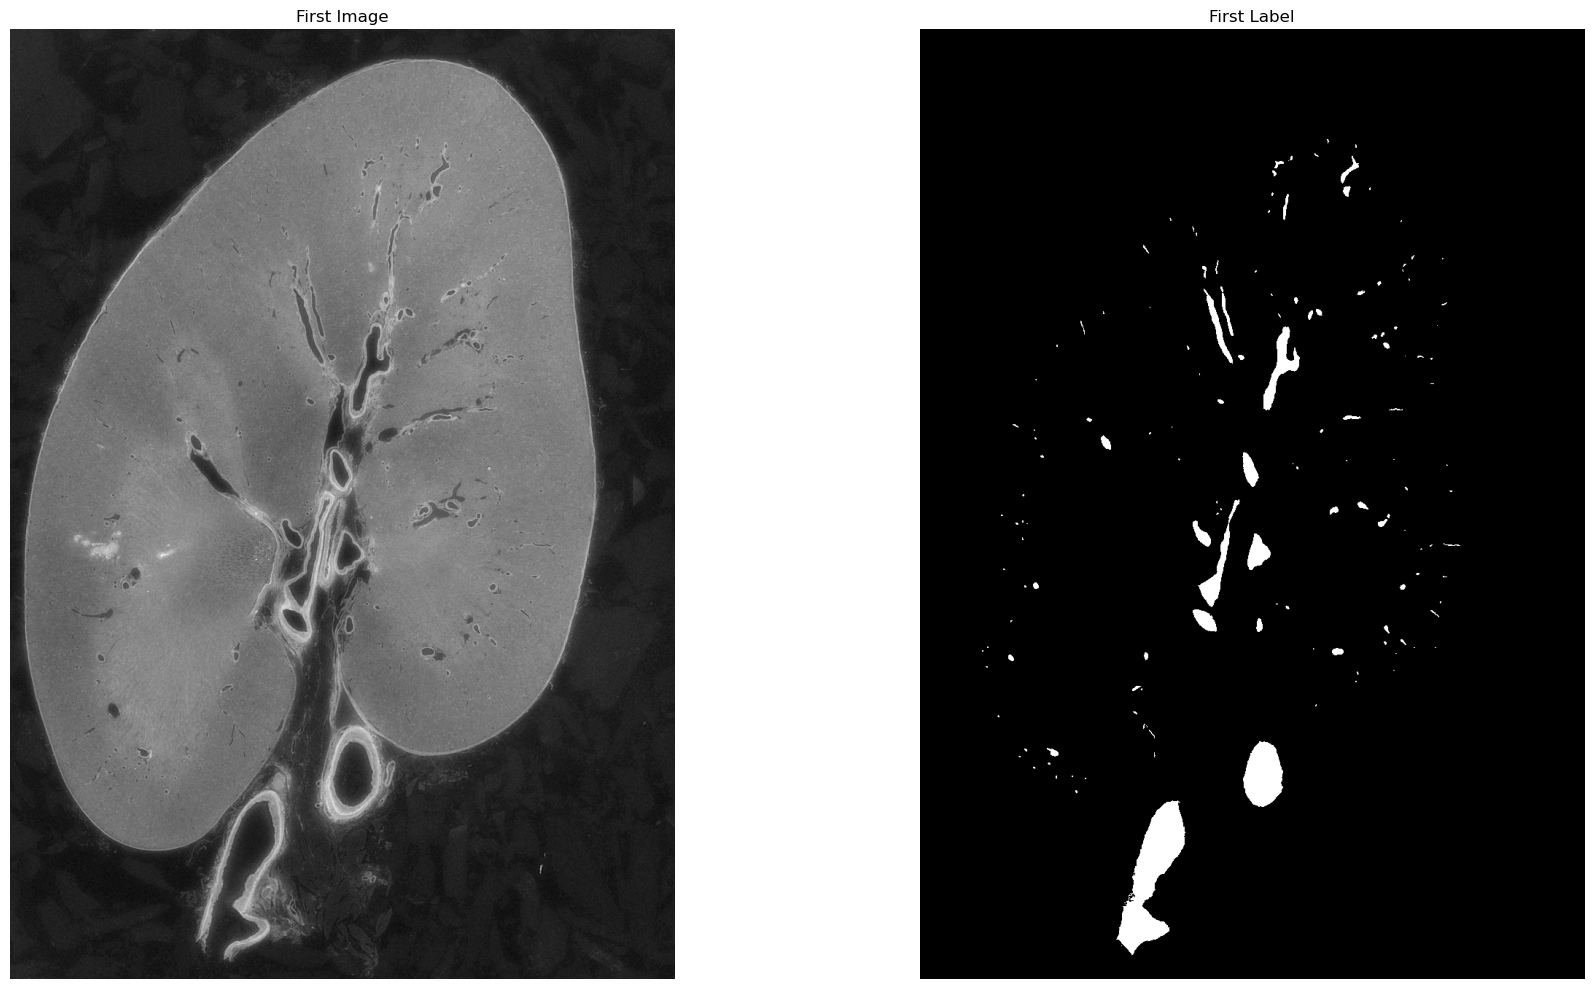

(1303, 912) (1303, 912)


In [29]:
dataset = 'kidney_1_dense'

images_path = os.path.join('train', dataset, 'images')
labels_path = os.path.join('train', dataset, 'labels')

image_files = sorted([os.path.join(images_path, f) for f in os.listdir(images_path) if f.endswith('.tif')])
label_files = sorted([os.path.join(labels_path, f) for f in os.listdir(labels_path) if f.endswith('.tif')])

def show_images(images,titles= None, cmap='gray'):
    n = len(images)
    fig, axes = plt.subplots(1, n, figsize=(20, 10))
    if not isinstance(axes, np.ndarray):
        axes = [axes]
    for idx, ax in enumerate(axes):
        ax.imshow(images[idx], cmap=cmap)
        if titles:
            ax.set_title(titles[idx])
        ax.axis('off')
    plt.tight_layout()
    plt.show()

first_image = tiff.imread(image_files[981])
first_label = tiff.imread(label_files[981])

first_image = cv2.resize(first_image, (1024, 1024))
first_label = cv2.resize(first_label, (1024, 1024))

show_images([first_image, first_label], titles=['First Image', 'First Label'])
print(first_image.shape, first_label.shape)

In [62]:
isinstance(first_image, np.ndarray)
isinstance(first_label, np.ndarray)

True

### 1.1 Image Tensor

C:\Users\USER\AppData\Local\Temp\ipykernel_16460\3688829706.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensor = torch.tensor(tensor)


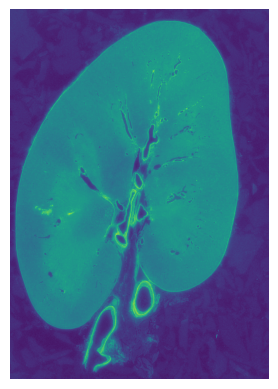

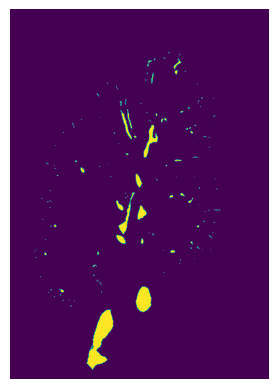

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


In [81]:
def show_tensor_image(tensor):
    if len(tensor.shape) == 4:
        tensor = tensor.squeeze(0)

    tensor = torch.tensor(tensor)
    numpy_image = tensor.cpu().numpy()

    if len(numpy_image.shape) == 3 and numpy_image.shape[0] == 1:
        numpy_image = numpy_image.squeeze(0)

    if len(numpy_image.shape) == 3:
        numpy_image = numpy_image.transpose(1, 2, 0)

    plt.imshow(numpy_image)
    plt.axis('off')
    plt.show()

    return tensor  # Return the original tensor

# Convert images to tensors
first_image_tensor = torch.from_numpy(first_image.astype(np.float32))
first_label_tensor = torch.from_numpy(first_label.astype(np.float32))

# Display and get the tensors back
first_tensor_image = show_tensor_image(first_image_tensor)
first_tensor_label = show_tensor_image(first_label_tensor)

print(first_label_tensor)

In [54]:
print(first_tensor_image.shape, first_tensor_label.shape)
print(first_tensor_image.dtype, first_tensor_label.dtype)
is_tensor_image = isinstance(first_tensor_image, torch.Tensor)
is_tensor_label = isinstance(first_tensor_label, torch.Tensor)
print(is_tensor_image, is_tensor_label)

torch.Size([1303, 912]) torch.Size([1303, 912])
torch.float32 torch.float32
True True


## 2. Image Augmentation

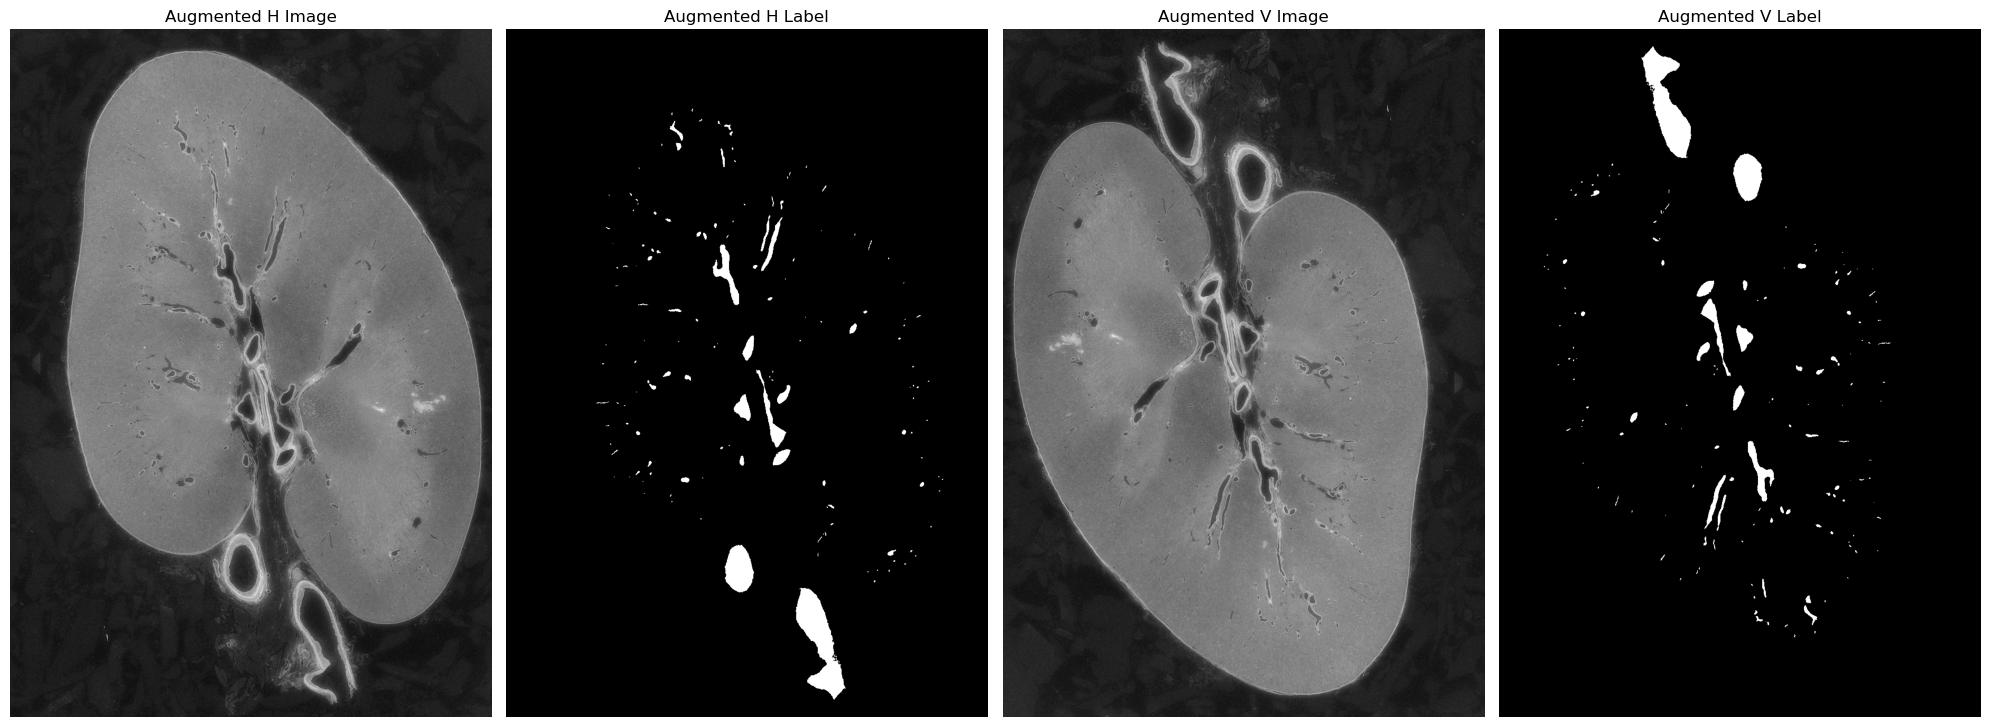

In [82]:
def augment_image(image, mask):
    # Define the augmentation pipeline
    horizontal_flip = A.Compose([
        A.HorizontalFlip(p=1.0)
    ])
    vertical_flip = A.Compose([
        A.VerticalFlip(p=1.0)
    ])

    # Apply the transformations
    horizontalflip = horizontal_flip(image=image, mask=mask)
    verticalflip = vertical_flip(image=image, mask=mask)

    augmented_h_image, augmented_h_mask = horizontalflip['image'], horizontalflip['mask']
    augmented_v_image, augmented_v_mask = verticalflip['image'], verticalflip['mask']

    return augmented_h_image, augmented_h_mask, augmented_v_image, augmented_v_mask

# Perform the augmentation
augmented_h_image, augmented_h_label, augmented_v_image, augmented_v_label = augment_image(first_image, first_label)

# Display the augmented image and mask
show_images([augmented_h_image, augmented_h_label, augmented_v_image, augmented_v_label], titles=['Augmented H Image', 'Augmented H Label', 'Augmented V Image', 'Augmented V Label'])

# np augmented change to tensor make it to batch and use that augmented tensor to the model for training